### Feature selection
- Previous part of preprocessing of `Boost` notebook.

In [1]:
from scipy.stats import chi2_contingency 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import optuna
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_log_error
from joblib import parallel_backend
import time
from sklearn.model_selection import KFold
from scipy.special import inv_boxcox
from scipy.stats import boxcox
## Data Preprocessing
### Feature Engineering
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['feature_12'] = pd.to_datetime(train['feature_12'])
train['year'] = (train['feature_12']).dt.year
train['month'] = (train['feature_12']).dt.month
train['day'] = (train['feature_12']).dt.day
train['dow'] = (train['feature_12']).dt.dayofweek
train['week'] = train['feature_12'].dt.isocalendar().week

train['month_sin'] = np.sin(2 * np.pi * (train['month'] - 1) / 12)
train['month_cos'] = np.cos(2 * np.pi * (train['month'] - 1) / 12)
train['day_sin'] = np.sin(2 * np.pi * (train['day'] - 1) / 31)
train['day_cos'] = np.cos(2 * np.pi * (train['day'] - 1) / 31)

train['group'] = (train['year'] - 2020) * 48 + train['month'] *4 + train['day'] // 7

test['feature_12'] = pd.to_datetime(test['feature_12'])
test['year'] = (test['feature_12']).dt.year
test['month'] = (test['feature_12']).dt.month
test['day'] = (test['feature_12']).dt.day
test['dow'] = (test['feature_12']).dt.dayofweek
test['week'] = (test['feature_12']).dt.isocalendar().week

test['month_sin'] = np.sin(2 * np.pi * (test['month'] - 1) / 12)
test['month_cos'] = np.cos(2 * np.pi * (test['month'] - 1) / 12)
test['day_sin'] = np.sin(2 * np.pi * (test['day'] - 1) / 31)
test['day_cos'] = np.cos(2 * np.pi * (test['day'] - 1) / 31)

test['group'] = (test['year'] - 2020) * 48 + test['month'] *4 + test['day'] // 7

train['feature_0_squared'] = train['feature_0'] ** 2
test['feature_0_squared'] = test['feature_0'] ** 2
train['Age_squared'] = train['Age'] ** 2
test['Age_squared'] = test['Age'] ** 2
train['feature_0_feature_5'] = train['feature_0'] * train['feature_5']
test['feature_0_feature_5'] = test['feature_0'] * test['feature_5']
train['feature_0_Age'] = train['feature_0'] * train['Age']
test['feature_0_Age'] = test['feature_0'] * test['Age']
train['group_Age'] = train['group'] * train['Age']
test['group_Age'] = test['group'] * test['Age']



train = train.drop(columns=['feature_12'])
test = test.drop(columns=['feature_12'])
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])
numerical_missing_vals = ['Age', 'feature_0', 'feature_2', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11']
categorical_missing_vals = ['feature_1', 'feature_4', 'feature_13']

for c in numerical_missing_vals + categorical_missing_vals:
    train[f"is_{c}_na"] = train[c].isna().astype(int)
    test[f"is_{c}_na"] = test[c].isna().astype(int)    
    
# Drop is_feature_9_na and is_feature_11_na since they are almost constant
train = train.drop(columns=['is_feature_9_na', 'is_feature_11_na'])
test = test.drop(columns=['is_feature_9_na', 'is_feature_11_na'])

# Use simple imputer to fill missing values
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='median')

train[numerical_missing_vals] = numerical_imputer.fit_transform(train[numerical_missing_vals])
train[categorical_missing_vals] = train[categorical_missing_vals].fillna('Unknown')

test[numerical_missing_vals] = numerical_imputer.transform(test[numerical_missing_vals])
test[categorical_missing_vals] = test[categorical_missing_vals].fillna('Unknown')


## Encoding 
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
features_for_one_hot = ['Gender', 'feature_1', 'feature_4', 'feature_6', 'feature_16']
features_for_label = ['feature_14']
features_for_ordinal = ['feature_3', 'feature_7', 'feature_13', 'feature_15']

# Create frequency encoding for categorical features
for feature in features_for_one_hot + features_for_label + features_for_ordinal:
    train[feature + '_freq'] = train[feature].map(train[feature].value_counts())
    test[feature + '_freq'] = test[feature].map(train[feature].value_counts())
    
ordinal_features = {
    'feature_3':['High School', "Bachelor's", "Master's", 'PhD'],
    'feature_7': ['Basic', 'Comprehensive', 'Premium'],
    'feature_13': ['Poor', 'Average', 'Good'] ,
    'feature_15': ['Rarely', 'Monthly', 'Weekly', 'Daily'],
}
for feature in features_for_one_hot:
    train = pd.get_dummies(train, columns=[feature], prefix=[feature], dtype=int)
    test = pd.get_dummies(test, columns=[feature], prefix=[feature], dtype=int)
    
for feature in features_for_label:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])
    
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
    train[feature] = oe.fit_transform(train[[feature]]).flatten()
    test[feature] = oe.transform(test[[feature]]).flatten()
# # Check the outliers of new features


features_for_robust = ['feature_0', 'feature_0_squared', 'feature_0_feature_5', 'feature_0_Age', 'group_Age']
for feature in features_for_robust:
    train[feature] = np.log1p(train[feature])
    test[feature] = np.log1p(test[feature])
X_train = train.drop(columns=['target'])
y_train = train['target']

y_train = np.log1p(y_train)
### Retyping

# Convert int64 or int32 to int8
for col in X_train.select_dtypes(include=[np.int64, np.int32]).columns:
    X_train[col] = X_train[col].astype(np.int8)
    test[col] = test[col].astype(np.int8)
    
for col in test.select_dtypes(include=[np.float64]).columns:
    X_train[col] = X_train[col].astype(np.float32)
    test[col] = test[col].astype(np.float32)

c:\Users\Welcome\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Welcome\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
import lightgbm as lgb

- Since we all knew that not all features have strong correlation with `target`, therefore in this case we used `lightgbm` instance to see **feature importances**.

[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 63
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 6.593889


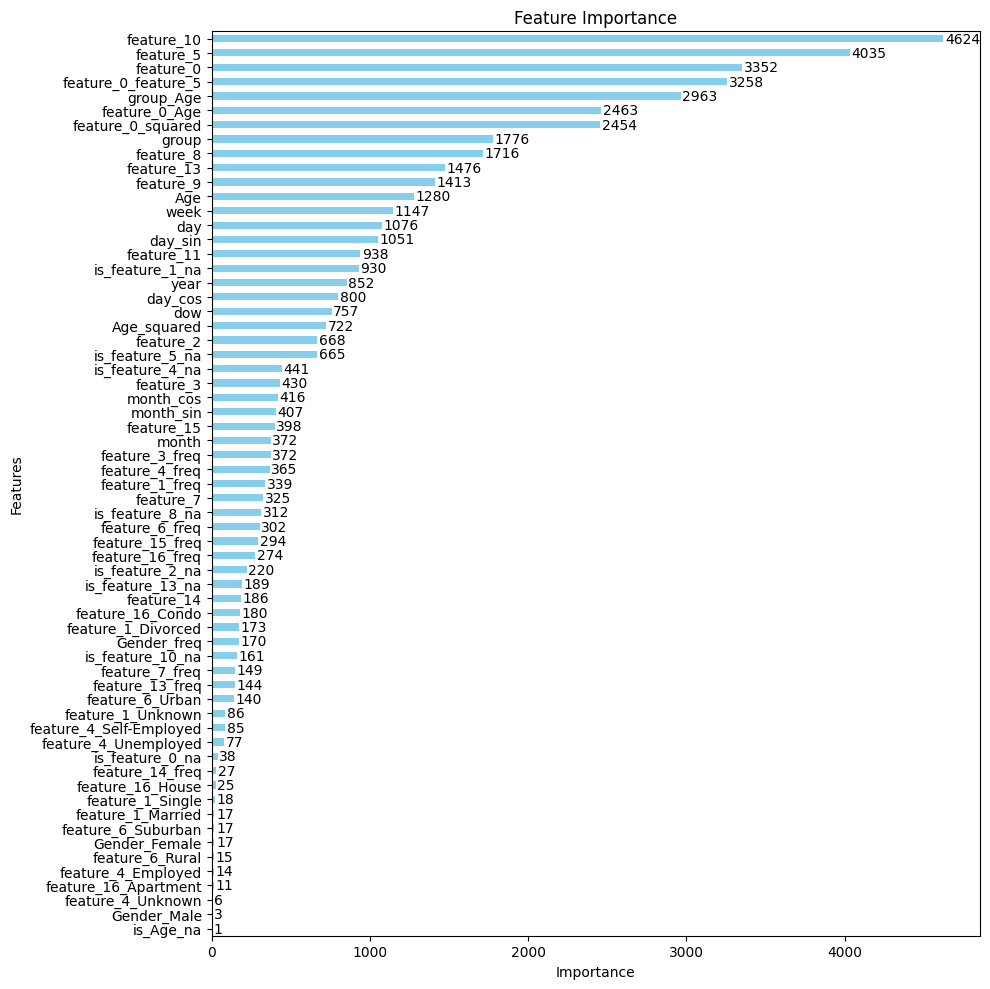

In [3]:


# Cập nhật lgb_params
lgb_params = {
    'data_sample_strategy': 'goss',  # Sử dụng tham số mới
    'objective': 'regression_l2',
    'n_estimators': 916,
    'max_depth': 20,
    'num_leaves': 53,
    'learning_rate': 0.01131282494413561,
    'subsample': 0.7373998287025486,
    'colsample_bytree': 0.8954487807505581,
    'min_child_weight': 4,
    'reg_alpha': 8.681326679335126e-05,
    'reg_lambda': 0.0007972265802055076,
    'top_rate': 0.3031279846721444,
    'other_rate': 0.3198197073867703,
    'force_col_wise': True,  # Tùy chọn để giảm bộ nhớ
    'random_state': 42
}

# Huấn luyện mô hình LightGBM
LGB_TMP = lgb.LGBMRegressor(**lgb_params)
lgb_tmp = LGB_TMP.fit(X_train, y_train)

# Tính toán độ quan trọng của các đặc trưng
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

importances = pd.Series(lgb_tmp.feature_importances_, index=feature_names, name='Feature Importance')
importances = importances.sort_values(ascending=True)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(10, 10))
ax = importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()

# Thêm chú thích vào biểu đồ
for i, v in enumerate(importances):
    plt.text(v + 10, i, str(v), va='center')

plt.show()

Surprisingly, we can see that most of categorical features have really low importance. After many trials, we decided that threshold 200 is the optimal one for us to eliminate low important features.

In [4]:
# Chuyển đổi importances từ Series thành DataFrame
importances_df = importances.reset_index()
importances_df.columns = ['Feature', 'Feature Importance']  # Đặt tên cột

# Lọc các đặc trưng có độ quan trọng thấp
low_importance_features = importances_df[importances_df['Feature Importance'] < 200]['Feature'].tolist()
low_importance_features

['is_Age_na',
 'Gender_Male',
 'feature_4_Unknown',
 'feature_16_Apartment',
 'feature_4_Employed',
 'feature_6_Rural',
 'Gender_Female',
 'feature_6_Suburban',
 'feature_1_Married',
 'feature_1_Single',
 'feature_16_House',
 'feature_14_freq',
 'is_feature_0_na',
 'feature_4_Unemployed',
 'feature_4_Self-Employed',
 'feature_1_Unknown',
 'feature_6_Urban',
 'feature_13_freq',
 'feature_7_freq',
 'is_feature_10_na',
 'Gender_freq',
 'feature_1_Divorced',
 'feature_16_Condo',
 'feature_14',
 'is_feature_13_na']

In [5]:
X_train = X_train.drop(columns=low_importance_features)
X_train.dtypes

Age                    float32
feature_0              float32
feature_2              float32
feature_3              float32
feature_5              float32
feature_7              float32
feature_8              float32
feature_9              float32
feature_10             float32
feature_11             float32
feature_13             float32
feature_15             float32
year                      int8
month                     int8
day                       int8
dow                       int8
week                    UInt32
month_sin              float32
month_cos              float32
day_sin                float32
day_cos                float32
group                     int8
feature_0_squared      float32
Age_squared            float32
feature_0_feature_5    float32
feature_0_Age          float32
group_Age              float32
is_feature_2_na           int8
is_feature_5_na           int8
is_feature_8_na           int8
is_feature_1_na           int8
is_feature_4_na           int8
feature_

In [6]:
X_train.columns

Index(['Age', 'feature_0', 'feature_2', 'feature_3', 'feature_5', 'feature_7',
       'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_13',
       'feature_15', 'year', 'month', 'day', 'dow', 'week', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'group', 'feature_0_squared',
       'Age_squared', 'feature_0_feature_5', 'feature_0_Age', 'group_Age',
       'is_feature_2_na', 'is_feature_5_na', 'is_feature_8_na',
       'is_feature_1_na', 'is_feature_4_na', 'feature_1_freq',
       'feature_4_freq', 'feature_6_freq', 'feature_16_freq', 'feature_3_freq',
       'feature_15_freq'],
      dtype='object')